# Identify a Pokémon from an image using NexosAPI

This notebook demonstrates how to:
- Configure logging and load environment variables for NexosAPI
- Fetch and display an image of an unknown Pokémon
- Build a chat completion request that includes the image and a web search tool
- Send the request and print the structured JSON response containing the predicted name and confidence

Prerequisites:
- A valid NexosAPI setup with credentials available via environment variables (e.g., in a `.env` file)
- Internet access (to fetch the image and use the search tool)


## Setup: logging and environment variables

Configure logging for better visibility into API operations and set environment variables so NexosAPI loads your `.env` file automatically. Adjust `NEXOSAI_INIT__DOTENV_PATH` to point to your local `.env` file containing credentials and configuration.


In [1]:
import logging
import os
import json

# Set the logging level to desired verbosity
# This will help in debugging by showing detailed logs of the operations
# and interactions with the API.
from nexosapi.common.logging import setup_logging

LOGGING_LEVEL = logging.INFO
setup_logging(level=LOGGING_LEVEL)

# Set the environment variable to use dotenv to load environment variables

os.environ["NEXOSAI_INIT__DOTENV_PATH"] = (
    "/Users/kamilrybacki/Projects/nexos.api/examples/.env"  # Set the path to the .env file
)
os.environ["NEXOSAI_INIT__LOAD_DOTENV"] = "true"

## Fetch and display the target image

Download the image from a URL and render it inline to verify the input. We use `requests` to fetch the content and `IPython.display.Image` to display it in the notebook.


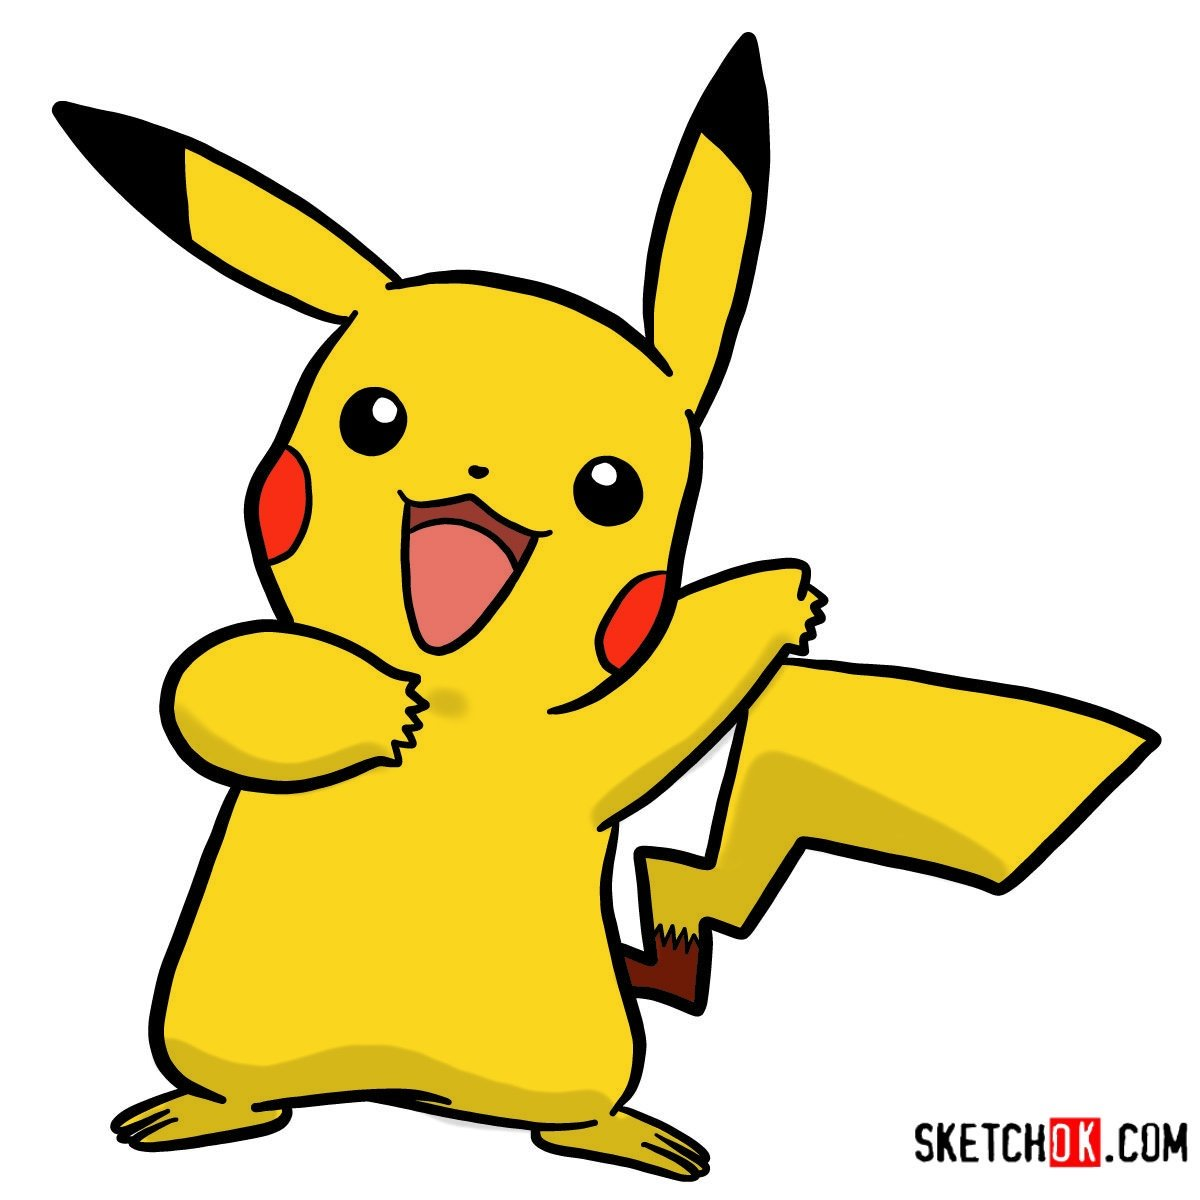

In [2]:
from IPython.display import Image, display
from requests import request

UNKNOWN_POKEMON_IMAGE_URL = "https://sketchok.com/images/articles/06-anime/003-pokemon/01/10.jpg"

# Show the image behind the URL
response = request("GET", UNKNOWN_POKEMON_IMAGE_URL)
image_content = response.content

if response.status_code == 200:
    pokemon_image = Image(image_content, width=300, height=300)
    display(pokemon_image)

## Build a chat completion request with image and search tool

Create a request that instructs the assistant to identify the Pokémon from the provided image and return a JSON response with `name`, `confidence`, and `url`. We then:
- Add a user message and attach the image URL
- Enable the search engine tool to aid recognition
- Print the prepared request payload for inspection


In [3]:
from nexosapi.api.endpoints import chat

# Define the parameters for the chat completion request
params = {
    "model": "8ef67c2a-5f50-4b19-acfe-5c2e404dbc95",
    "messages": [
        {
            "content": """
            You are a helpful assistant that can identify Pokemon from images provided to you as input.
            Use the image URL provided in the user message to analyze the image.
            You can use external APIs or libraries to assist with image recognition.
            Return the name of the Pokemon with the confidence score 
            where confidence is a value between 0 and 1.
        """
        }
    ],
}

# Generate the initial request with the prepared parameters, we will add Google search in a sec
chat.completions.request.prepare(params)

# Show initial request as JSON
print(json.dumps(chat.completions.request.dump(), indent=4, sort_keys=True, ensure_ascii=False))

2025-08-17 21:43:56,534 - root - INFO - [SDK] Dependencies automatically wired.


{
    "frequency_penalty": 0.0,
    "messages": [
        {
            "content": "\n            You are a helpful assistant that can identify Pokemon from images provided to you as input.\n            Use the image URL provided in the user message to analyze the image.\n            You can use external APIs or libraries to assist with image recognition.\n            Return the name of the Pokemon with the confidence score \n            where confidence is a value between 0 and 1.\n        ",
            "role": "user"
        }
    ],
    "modalities": [
        "text"
    ],
    "model": "8ef67c2a-5f50-4b19-acfe-5c2e404dbc95",
    "n": 1,
    "presence_penalty": 0.0,
    "service_tier": "auto",
    "temperature": 1.0,
    "top_p": 1.0
}


## Define the response model for LLM output

In the next cell we will define a payload model using Pydantic to validate the response from the LLM. 
This ensures that the output is structured as expected, with fields for `name`, `confidence`, and `url`.

To set this schema, we will use `set_response_structure()` method of the `ChatCompletionsRequest`'s request manager, passing in the Pydantic model we just defined.
You can also pass the schema in form of a dictionary, where the keys are the field names and the values are the expected types,
however using Pydantic models is recommended for better validation and type checking (also the JSON schemas are more verbose in this way)

The response will be still available as a string in the `response.choices[0].message.content` field,
however it will need to be deserialized into the Pydantic model for validation.

In [4]:
# Add image and question about the Pokemon
from pydantic import BaseModel
import pydantic


chat.completions.request.add_text_message(text="Who's that Pokemon?")
chat.completions.request.add_image_to_last_message(image_url=UNKNOWN_POKEMON_IMAGE_URL)

# Add a search engine tool to the request to help identify the Pokemon
chat.completions.request.with_search_engine_tool(
    options={
        "search_context_size": "medium",
    },
)

# Set response structure


class PokemonIdentificationResult(BaseModel):
    name: str = pydantic.Field(description="Name of the identified Pokemon")
    confidence: float = pydantic.Field(description="Confidence score of the identification")
    reasons: list[str] = pydantic.Field(description="Reasons for the identification")


chat.completions.request.set_response_structure(PokemonIdentificationResult)

# Show the request before sending it
print(json.dumps(chat.completions.request.dump(), indent=4, sort_keys=True, ensure_ascii=False))

{
    "frequency_penalty": 0.0,
    "messages": [
        {
            "content": "\n            You are a helpful assistant that can identify Pokemon from images provided to you as input.\n            Use the image URL provided in the user message to analyze the image.\n            You can use external APIs or libraries to assist with image recognition.\n            Return the name of the Pokemon with the confidence score \n            where confidence is a value between 0 and 1.\n        ",
            "role": "user"
        },
        {
            "content": [
                {
                    "text": "Who's that Pokemon?",
                    "type": "text"
                },
                {
                    "image_url": {
                        "url": "https://sketchok.com/images/articles/06-anime/003-pokemon/01/10.jpg"
                    },
                    "type": "image_url"
                }
            ],
            "role": "user"
        },
        {
       

## Send the request and display the response

Send the prepared request asynchronously and print the model's response as JSON. If no pending request exists, reload the last prepared request. Ensure your notebook environment supports top-level `await` (Jupyter does). The response should include the predicted Pokémon name, confidence score, and the image URL.

Note: This cell also uses `json.dumps(...)` to pretty-print the response.


In [5]:
if chat.completions.request.pending is None:
    chat.completions.request.reload_last()
response = await chat.completions.request.send()
print(json.dumps(response.model_dump(), indent=4, sort_keys=True, ensure_ascii=False))

2025-08-17 21:44:01,379 - httpx - INFO - HTTP Request: POST https://api.nexos.ai/v1/chat/completions "HTTP/1.1 200 OK"


{
    "choices": [
        {
            "finish_reason": "stop",
            "index": 0,
            "message": {
                "annotations": [],
                "content": "{\"name\":\"Pikachu\",\"confidence\":0.98,\"reasons\":[\"Distinctive yellow color\",\"Pointed ears with black tips\",\"Red cheeks\",\"Tail shaped like a lightning bolt\",\"Popular mascot of the Pokémon franchise\"]}",
                "role": "assistant"
            }
        }
    ],
    "created": 1755459839,
    "id": "chatcmpl-C5daJzAaRUkdazWwF7D14Z57YPHi6",
    "model": "gpt-4o-mini-2024-07-18",
    "object": "chat.completion",
    "service_tier": "default",
    "system_fingerprint": "fp_51db84afab",
    "usage": {
        "completion_tokens": 46,
        "prompt_tokens": 25723,
        "total_tokens": 25769
    }
}


In [6]:
# Feed the response content through the Pydantic model for validation
response_content = response.choices[0].message.content
deserialized_content = json.loads(response_content)
response_data = PokemonIdentificationResult(**deserialized_content)

# Show the validated response data
print(json.dumps(response_data.model_dump(), indent=4, sort_keys=True, ensure_ascii=False))

{
    "confidence": 0.98,
    "name": "Pikachu",
    "reasons": [
        "Distinctive yellow color",
        "Pointed ears with black tips",
        "Red cheeks",
        "Tail shaped like a lightning bolt",
        "Popular mascot of the Pokémon franchise"
    ]
}
